# Community detection

In [1]:
import networkx as nx
import random

## Exercice 1 - Simple bechmark 

In [8]:
NUMBER_OF_CLUSTERS = 4
CLUSTER_SIZE = 100
NUMBER_OF_NODES = NUMBER_OF_CLUSTERS * CLUSTER_SIZE
prob_P = 0.1
prob_Q = 0.0002
COLORS = ['blue','red','yellow','green','purple']
COULEUR = [COLORS[i//CLUSTER_SIZE] for i in range(NUMBER_OF_NODES)]

option = {
    'node_size' : 5,
    'node_color' : COULEUR
}

FILES = ["com-youtube.ungraph.txt","com-youtube.all.cmty.txt","com-youtube.top5000.cmty.txt"]

In [9]:
def simple_bechmark():
    G = nx.Graph()
    G.add_nodes_from([i for i in range(NUMBER_OF_NODES) ])
    for i in range(NUMBER_OF_NODES):
        for j in range(i+1, NUMBER_OF_NODES):
            if i//CLUSTER_SIZE == j//CLUSTER_SIZE and random.random() < prob_P:
                G.add_edge(i,j)
            if i//CLUSTER_SIZE != j//CLUSTER_SIZE and random.random() < prob_Q:
                G.add_edge(i,j)
    return G

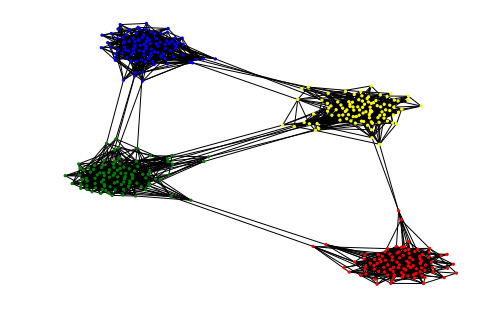

In [28]:
if True:
    prob_P = 0.1
    prob_Q = 0.0002
    nx.draw(simple_bechmark(),**option)

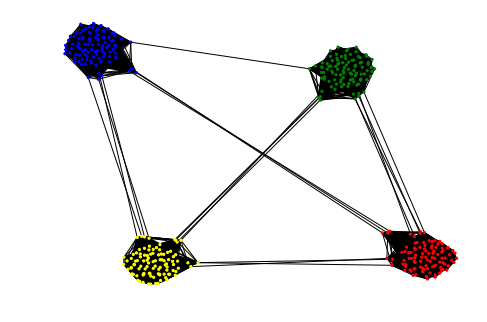

In [33]:
if True:
    prob_P = 0.1 * 5
    prob_Q = 0.0002
    nx.draw(simple_bechmark(),**option)

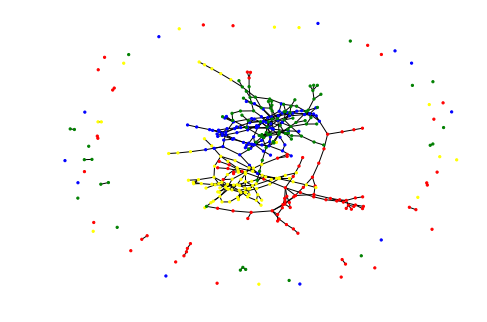

In [35]:
if True:
    prob_P = 0.1 / 5
    prob_Q = 0.0002
    nx.draw(simple_bechmark(),**option)

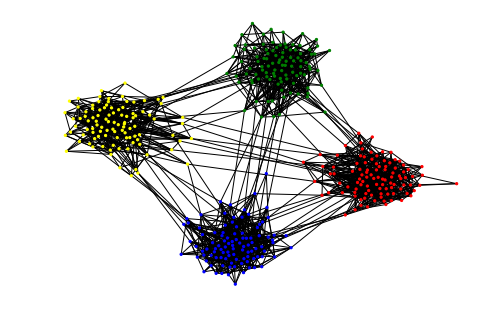

In [13]:
if True:
    prob_P = 0.1
    prob_Q = 0.0002 * 5
    nx.draw(simple_bechmark(),**option)

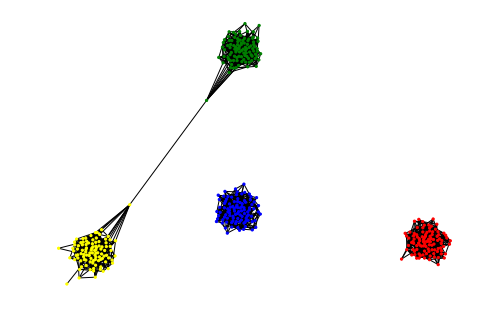

In [36]:
if True:
    prob_P = 0.1
    prob_Q = 0.0002 / 5
    nx.draw(simple_bechmark(),**option)

## Exercice 2 - Label propagation 

In [9]:
class Node(list):
    
    def __init__(self,num,label):
        list.__init__(self)
        self.num = num
        self.label = label
        
    def edges_list(self):
        return [(self.num,node.num) for node in self]
        
    def frequency_label(self):
        labels = {}
        for node in self:
            labels[node.label] = labels.get(node.label,0) + 1
        return labels
    
    def label_max_frequency(self,labels):
        MAX = None
        for label in labels.keys():
            if MAX is None or labels[MAX] < labels[label]:
                MAX = label
        return MAX
    
    def label_propagation(self):
        label = self.label_max_frequency(self.frequency_label())
        if self.label == label: return False
        else:
            self.label = label
            return True
            
        
    
        

In [10]:
class Graph(list):
    
    def __init__(self,nodes = [],options = {}):
        list.__init__(self,nodes)
        self.options = options
    
    def shuffle(self):
        random.shuffle(self)
        
    def label_propagation(self):
        modification = False
        for node in self:
            if node.label_propagation():
                modification = True
        return modification
    
    def scale_labels(self):
        labels = {}
        for node in self:
            if not node.label in labels:
                labels[node.label] = len(labels.keys())
        for node in self:
            node.label = labels[node.label]
    
    def nx_Graph(self):
        G = nx.Graph()
        D = {node.num : node for node in self}
        self = Graph([D[i] for i in range(len(self))],self.options)
        G.add_nodes_from([node.num for node in self])
        for node in self:
            G.add_edges_from(node.edges_list())
        if 'node_color' in self.options: 
            colors = [COLORS[node.label] for node in self]
            self.options['node_color'] = colors
        return G
    
    def number_of_communities(self):
        return len(set([node.label for node  in self if len(node) != 0]))
    
    def weight_of_communities(self):
        D = {}
        for node in self:
            D[node.label] = D.get(node.label,0) + 1
        return D
        
    def draw(self):
        nx.draw(self.nx_Graph(),**self.options)
        

In [11]:
def nodes_file(INPUT):
    iFile = open(INPUT,'r')
    lines = iFile.read()[:-1].split('\n')
    iFile.close()
    while lines[0][0] == '#': del lines[0]
    nodes = []
    if len(lines[0].split(' ')) == 2: SPACE = ' '
    else: SPACE = '\t'
    for line in lines:
        u,v = line.split(SPACE)
        u,v = int(u),int(v)
        if v >= len(nodes):
            nodes = nodes + [Node(i,i) for i in range(len(nodes),v+1)]
        nodes[u].append(nodes[v])
        nodes[v].append(nodes[u]) 
    return nodes

def label_propagation(INPUT = '',G = None, option = {}, print_draw = False,verbose = False):
    if G == None: G = Graph(nodes_file(INPUT),option)
    G.shuffle()
    while(G.label_propagation()): G.shuffle()
    G.scale_labels()
    if verbose: print("communities :",G.number_of_communities())
    if print_draw : G.draw()
    L = list(G.weight_of_communities().values())
    L.sort()
    return L[-20:]

## Exercice 3 - Validation 

In [12]:
import community
import networkx as nx
import matplotlib.pyplot as plt
import time
import random

def louvain(G):
    now = time.time()
    #first compute the best partition
    partition = community.best_partition(G)

    #drawing
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    count = 0.
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
    after = time.time()


    
    return [count,after-now]

In [13]:
def testing_Graph(CLUSTERS = [], P = 0.1, Q = 0.0002,option = {}):
    nodes = [Node(i,i) for i in range(sum(CLUSTERS)) ]
    current_cluster = 0
    clusters = [sum(CLUSTERS[:i+1]) for i in range(len(CLUSTERS))]
    for i in range(clusters[-1]):
        for j in range(i+1, clusters[-1]):
            if j < clusters[current_cluster] and random.random() < P:
                nodes[i].append(nodes[j])
                nodes[j].append(nodes[i])
            if j >= clusters[current_cluster] and random.random() < Q:
                nodes[i].append(nodes[j])
                nodes[j].append(nodes[i])
        if i == clusters[current_cluster] - 1:
            current_cluster += 1
    return Graph(nodes,option)
    

In [14]:
def random_clusters(nb_nodes,nb_clusters):
    clusters = []
    for i in range(nb_clusters):
        clusters.append(random.randint(1,(nb_nodes//nb_clusters)*2))
        nb_nodes -= clusters[-1]
    return clusters

In [15]:
def chrono(INPUT,timer = 300, nb_of_G = 1, nb_of_test = 3):
    
    iFile = open(INPUT, 'r')
    weight,communities = [],[]
    lines = iFile.read()[:-1].split('\n')
    if len(lines[0].split(' ')) == 2: SPACE = ' '
    else: SPACE = '\t'
    
    for line in lines:
        w,c = line.split(SPACE)
        weight.append(int(w))
        communities.append(int(c))
    iFile.close()
    
    CHRONO_LV = []
    CHRONO_LB = []
    LOUVAIN = False
    LABEL = False
    
    for i in range(len(weight)):
        w = weight[i]
        c = communities[i]
        CHRONO_LV.append([])
        CHRONO_LB.append([])
        for t in range(nb_of_G):
            _G = testing_Graph(random_clusters(w,c))
            for i in range(nb_of_test):
                if LOUVAIN: continue
                nx_G = _G.nx_Graph()
                start = time.time()
                louvain(nx_G)
                CHRONO_LV[-1].append(time.time() - start)
                TIME_LV = time.time() - start
            for i in range(nb_of_test):
                if LABEL: continue
                start = time.time()
                label_propagation(G = _G)
                CHRONO_LB[-1].append(time.time() - start)
                TIME_LB = time.time() - start
                for node in _G: node.label = node.num
            if TIME_LV > timer: LOUVAIN = True
            if TIME_LB > timer: LABEL = True
    VFile = open("louvain.time", 'w')
    for times in CHRONO_LV:
        VFile.write(str(sum(times)/len(times)) + '\n')
    VFile.close()
    BFile = open("label.time", 'w')
    for times in CHRONO_LB:
        BFile.write(str(sum(times)/len(times)) + '\n')
    BFile.close()
            

In [1]:
if False:
    chrono("W&C.txt")

## Exercice 4 - (Optional) New algorithm 